In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../src/')

In [3]:
from settings import *
from preprocess import *

In [4]:
carpediem, carpediem2 = load_carpediem()
carpediem = carpediem_icu(carpediem, carpediem2)

carpediem = carpediem_edps(carpediem)

In [5]:
df = carpediem[['Patient_id', 'ICU_stay', 'ICU_day', 'PaO2FIO2_ratio']]

In [6]:
df = df.merge(
    df.groupby(['Patient_id', 'ICU_stay']).size().to_frame('ICU_len').reset_index()
)

In [7]:
def msk(df, perc1=0, perc2=100, pat_id='Patient_id', stay_rank='icu_rank', stay_len='icu_len', day_rank='ICU_Day'):
    p1 = np.percentile(df[[pat_id, stay_rank, stay_len]].drop_duplicates()[stay_len],perc1)
    p2 = np.percentile(df[[pat_id, stay_rank, stay_len]].drop_duplicates()[stay_len],perc2)
    f = (df[stay_len] <= p2) & (df[stay_len] >= p1)
    df = df[f]
    tmp = df[[pat_id, stay_rank, day_rank]]
    tmp = tmp.assign(is_icu=1)
    mask = tmp.set_index([pat_id, stay_rank, day_rank]).unstack(day_rank).isna()
    idx = df[[pat_id, stay_rank, stay_len]].drop_duplicates().set_index([pat_id, stay_rank]).sample(50, random_state=9).sort_values(stay_len).index
    mask = mask.loc[idx,:]
    # sns.heatmap(mask)
    return df, mask, idx

[]

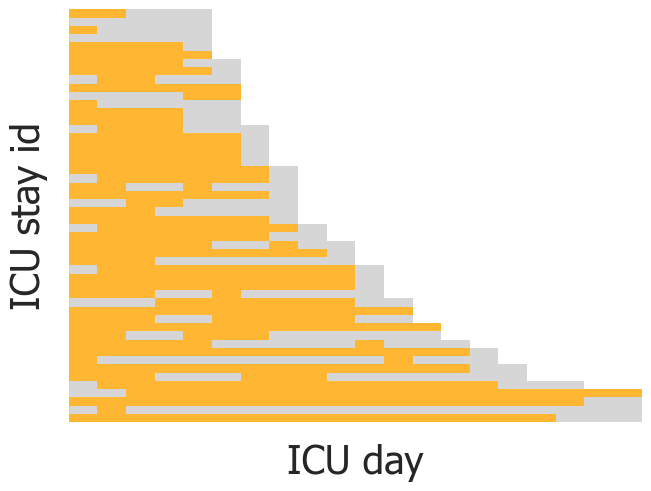

In [8]:
f1e, ax = plt.subplots(constrained_layout=True)
mymap = ['0.8', 'orange']
df, mask, idx = msk(df, 25, 75, pat_id='Patient_id', stay_rank='ICU_stay', stay_len='ICU_len', day_rank='ICU_day')

tmp = df[['Patient_id', 'ICU_stay', 'ICU_day', 'PaO2FIO2_ratio']]
tmp1 = ~tmp.set_index(['Patient_id', 'ICU_stay', 'ICU_day']).unstack('ICU_day').isna()
tmp1 = tmp1.loc[idx,:]

cmap = sns.color_palette(palette=None, n_colors=2) 
sns.heatmap(tmp1, mask=mask.values,ax=ax, cmap=mymap, cbar=False, alpha=0.8)

ax.set_xlabel('ICU day')
ax.set_xticks([])
ax.set_ylabel('ICU stay id')
ax.set_yticks([])
# ax.set_title("Bilirubin")

# plt.savefig("../plots/f2/F2a_240220.png", dpi=150, transparent=True, bbox_inches='tight')

In [9]:
mimic = pd.read_csv(os.path.join(mimic_dir, 'data.csv'), index_col=0)
mimic_edps = pd.read_csv(os.path.join(curated_dir, 'mimic_edps.csv'), index_col=0)
mimic = mimic.merge(mimic_edps, how='left')

In [10]:
df = mimic[['subject_id', 'stay_id', 'icu_day', 'pao2fio2ratio']]

In [11]:
df = df.merge(
    df.groupby(['subject_id', 'stay_id']).size().to_frame('ICU_len').reset_index()
)

[]

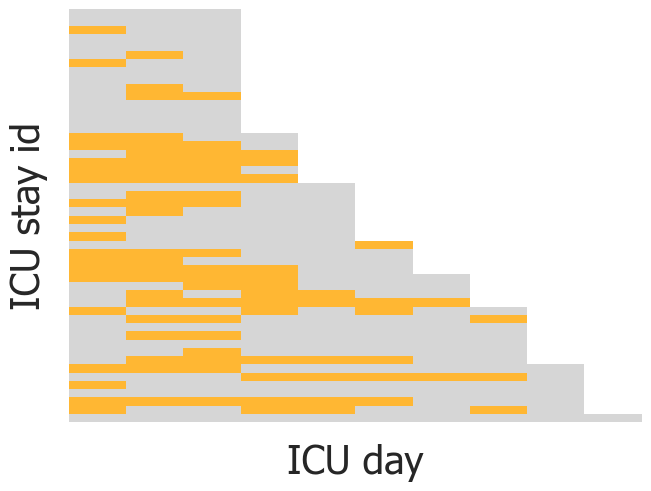

In [12]:
f1e, ax = plt.subplots(constrained_layout=True)
mymap = ['0.8', 'orange']
df, mask, idx = msk(df, 25, 75, pat_id='subject_id', stay_rank='stay_id', stay_len='ICU_len', day_rank='icu_day')

tmp = df[['subject_id', 'stay_id', 'icu_day', 'pao2fio2ratio']]
tmp1 = ~tmp.set_index(['subject_id', 'stay_id', 'icu_day']).unstack('icu_day').isna()
tmp1 = tmp1.loc[idx,:]

cmap = sns.color_palette(palette=None, n_colors=2) 
sns.heatmap(tmp1, mask=mask.values,ax=ax, cmap=mymap, cbar=False, alpha=0.8)

ax.set_xlabel('ICU day')
ax.set_xticks([])
ax.set_ylabel('ICU stay id')
ax.set_yticks([])
# ax.set_title("Bilirubin")

# plt.savefig("../plots/f2/F2a_240220.png", dpi=150, transparent=True, bbox_inches='tight')

In [13]:
dmos = ['Age', 'Ethnicity', 'Gender', 'Race', 'Smoking_status', 'BMI']
flgs = ['ECMO_flag', 'Intubation_flag', 'Hemodialysis_flag', 'CRRT_flag', 'Tracheostomy_flag']
sofs = [
    'P_F_ratio_points',
    'platelet_points',
    'bilirubin_points',
    'htn_points',
    'GCS_eye_opening',
    'GCS_motor_response',
    'GCS_verbal_response',
    'renal_points'
]
vtls = [
    'Temperature', 
    'Heart_rate', 
    'Systolic_blood_pressure',
    'Diastolic_blood_pressure',
    'Mean_arterial_pressure',
    'Respiratory_rate', 
    'Oxygen_saturation'
]
lbs = ['Urine_output', 'ABG_pH', 'ABG_PaCO2',
       'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes', 'Neutrophils',
       'Hemoglobin', 'Platelets', 'Bicarbonate', 'Creatinine', 'Albumin',
       'Bilirubin', 'CRP', 'D_dimer', 'Ferritin', 'LDH', 'Lactic_acid',
       'Procalcitonin']
vents = [
    'PEEP', 'FiO2', 'Plateau_Pressure', 'Lung_Compliance', 'PEEP_changes',
    'Respiratory_rate_changes', 'FiO2_changes'
]

In [14]:
df = carpediem[sofs+vtls+lbs]
df = (df.isna().sum()/df.shape[0]).to_frame('na_frac').reset_index(names='features').sort_values('na_frac')

In [15]:
condlist = [df.features.isin(i) for i in [sofs, vtls, lbs]]
choicelist = ['SOFA', 'vital', 'laboratory']
df = df.assign(group=np.select(condlist, choicelist))
df["group"] = pd.Categorical(df["group"], categories=['SOFA', 'vital', 'laboratory'])
df = df.sort_values(['group', 'na_frac'])
df = df.assign(completeness = 1-df.na_frac)

In [16]:
df[(df.group=='laboratory')&(df.completeness>0.9)].features.to_list()

['Platelets', 'WBC_count', 'Creatinine', 'Bicarbonate', 'Hemoglobin']

In [17]:
df[(df.group=='laboratory')&(df.completeness>0.5)].features.to_list()

['Platelets',
 'WBC_count',
 'Creatinine',
 'Bicarbonate',
 'Hemoglobin',
 'Urine_output',
 'Albumin',
 'Bilirubin',
 'Neutrophils',
 'Lymphocytes',
 'PaO2FIO2_ratio',
 'ABG_pH',
 'ABG_PaO2',
 'ABG_PaCO2']

(0.0, 1.01)

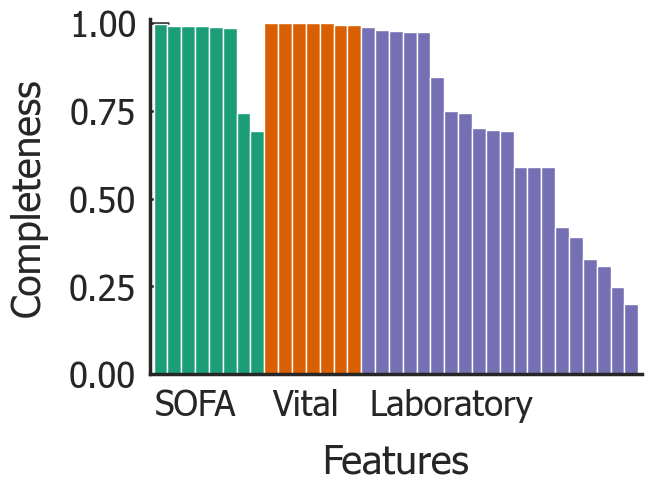

In [18]:
result_cat = df["group"].astype("category")
result_codes = result_cat.cat.codes.values
cmap = plt.cm.Dark2(range(df["group"].unique().shape[0]))

f2b, ax = plt.subplots(constrained_layout=True)
df.plot.bar(x='features', y='completeness', color=cmap[result_codes], legend=False, ax=ax, width=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(top=False, right=False)
ax.set_xlabel("Features")
ax.set_ylabel("Completeness")
ax.set_xticks([2.5,10.5,21], labels=['SOFA', 'Vital', 'Laboratory'], rotation=0)
ax.set_ylim(0,1.01)

# plt.savefig("../plots/f2/F2b_240326.png", dpi=150, transparent=True, bbox_inches='tight')

In [19]:
dmos1 = ['Age', 'BMI']
lbs1 = df[(df.group=='laboratory')&(df.completeness>0.9)].features.to_list()
lbs2 = df[(df.group=='laboratory')&(df.completeness>0.5)].features.to_list()

In [20]:
df = carpediem[sofs+vtls+dmos+flgs+vents+lbs]
df = (df.isna().sum()/df.shape[0]).to_frame('na_frac').reset_index(names='features').sort_values('na_frac')

In [21]:
condlist = [df.features.isin(i) for i in [sofs, vtls, dmos1, list(set(dmos) - set(dmos1)), flgs, lbs1, vents, list(set(lbs2) - set(lbs1)), list(set(lbs) - set(lbs2))]]
choicelist = ['SOFA sub-scores', 'Vitals', 'Demographics continuous', 'Demographics nominal', 'Flags', 'Labs set 1', 'Ventilation', 'Labs set 2', 'Labs set 3']
df = df.assign(group=np.select(condlist, choicelist))
df["group"] = pd.Categorical(df["group"], categories=choicelist)
df = df.sort_values(['group', 'na_frac'])

In [22]:
df.columns = ['Features', 'NA fraction', 'Group']

In [23]:
# df.to_csv("../data/feature_summary_script.csv", index=False)

In [24]:
df = df.assign(Completeness = 1-df['NA fraction'])

In [25]:
groups = df['Group'].unique()
palette = sns.color_palette('Set2', len(groups))
color_mapping = dict(zip(groups, palette))

In [26]:
color_mapping = {
    'SOFA sub-scores': 'C0',
    'Vitals': 'C1',
    'Demographics continuous': (0.2, 0.6274509803921569, 0.17254901960784313),
    'Demographics nominal': (0.6980392156862745,0.8745098039215686,0.5411764705882353),
    'Flags': 'C4',
    'Ventilation': 'C6',
    'Labs set 1': sns.color_palette('Greys_r', 3)[0],
    'Labs set 2': sns.color_palette('Greys_r', 3)[1],
    'Labs set 3': sns.color_palette('Greys_r', 3)[2]
}

In [27]:
df.Group = pd.Categorical(df.Group, categories=list(color_mapping.keys()))

In [28]:
df = df.sort_values(['Group', 'NA fraction'])

([], [])

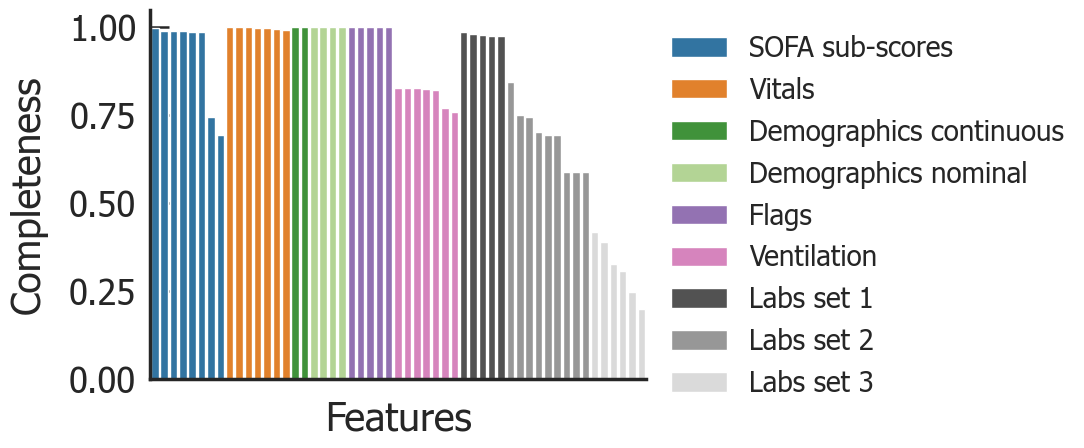

In [29]:
sns.barplot(data=df, x='Features', y='Completeness', hue='Group', palette=color_mapping, hue_order=list(color_mapping.keys()))
sns.move_legend(plt.gca(), bbox_to_anchor=(1, 1), loc='upper left', title='', frameon=False)
plt.xticks(ticks=[], labels=[], rotation=90)
# plt.savefig("../plots/240530_feature_completeness_script.png", dpi=150, transparent=True, bbox_inches='tight')

In [30]:
dmos = ['age', 'bmi']
sofs = [
    'respiration_24hours', 
    'coagulation_24hours',
    'liver_24hours', 
    'cardiovascular_24hours', 
    'gcs_motor', 'gcs_verbal', 'gcs_eyes',
    'renal_24hours'
]
vtls = [
    'heart_rate', 
    'sbp', 
    'dbp',
    'mbp',
    'resp_rate', 
    'temperature',
    'spo2'
]
lbs = ['uo_24hr', 'po2', 'pco2', 'ph', 'pao2fio2ratio', 'totalco2',
       'hemoglobin', 'hematocrit', 'lactate', 'wbc', 'basophils_abs',
       'eosinophils_abs', 'lymphocytes_abs', 'monocytes_abs',
       'neutrophils_abs', 'mch', 'mchc', 'mcv',
       'platelet', 'rbc', 'rdw', 'albumin', 'aniongap', 'bicarbonate', 'bun',
       'calcium', 'chloride', 'creatinine', 'glucose', 'sodium', 'potassium', 'bilirubin_total', 'alt', 'alp',
       'ast', 'ld_ldh', 'crp', 'd_dimer', 'inr', 'pt', 'ptt', 'ferritin']

In [31]:
df = mimic[sofs+vtls+lbs]
df = (df.isna().sum()/df.shape[0]).to_frame('na_frac').reset_index(names='features').sort_values('na_frac')

(0.0, 1.01)

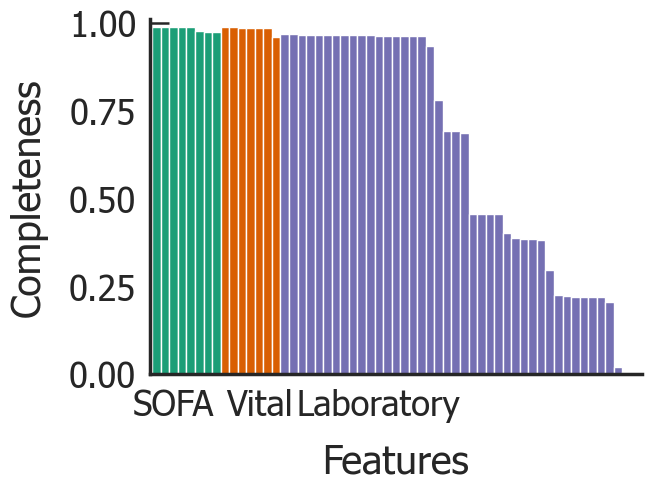

In [32]:
condlist = [df.features.isin(i) for i in [sofs, vtls, lbs]]
choicelist = ['SOFA', 'vital', 'laboratory']
df = df.assign(group=np.select(condlist, choicelist))
df["group"] = pd.Categorical(df["group"], categories=['SOFA', 'vital', 'laboratory'])
df = df.sort_values(['group', 'na_frac'])
df = df.assign(completeness = 1-df.na_frac)

result_cat = df["group"].astype("category")
result_codes = result_cat.cat.codes.values
cmap = plt.cm.Dark2(range(df["group"].unique().shape[0]))

f2b, ax = plt.subplots(constrained_layout=True)
df.plot.bar(x='features', y='completeness', color=cmap[result_codes], legend=False, ax=ax, width=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(top=False, right=False)
ax.set_xlabel("Features")
ax.set_ylabel("Completeness")
ax.set_xticks([2,12,26], labels=['SOFA', 'Vital', 'Laboratory'], rotation=0)
ax.set_ylim(0,1.01)

# plt.savefig("../plots/mimiciv/F2b_240326.png", dpi=150, transparent=True, bbox_inches='tight')

In [33]:
lbs1 = df[(df.group=='laboratory')&(df.completeness>0.9)].features.to_list()
lbs2 = df[(df.group=='laboratory')&(df.completeness>0.5)].features.to_list()

In [34]:
df = mimic[sofs+vtls+dmos+lbs]
df = (df.isna().sum()/df.shape[0]).to_frame('na_frac').reset_index(names='features').sort_values('na_frac')

In [35]:
condlist = [df.features.isin(i) for i in [sofs, vtls, dmos, lbs1,list(set(lbs2) - set(lbs1)), list(set(lbs) - set(lbs2))]]
choicelist = ['SOFA sub-scores', 'Vitals', 'Demographics', 'Labs set 1', 'Labs set 2', 'Labs set 3']
df = df.assign(group=np.select(condlist, choicelist))
df["group"] = pd.Categorical(df["group"], categories=choicelist)
df = df.sort_values(['group', 'na_frac'])

In [36]:
df.columns = ['Features', 'NA fraction', 'Group']

In [37]:
# df.to_csv("../data/feature_summary_mimic.csv", index=False)

In [38]:
df = df.assign(Completeness = 1-df['NA fraction'])

In [39]:
color_mapping['Demographics'] = (0.2, 0.6274509803921569, 0.17254901960784313)

([], [])

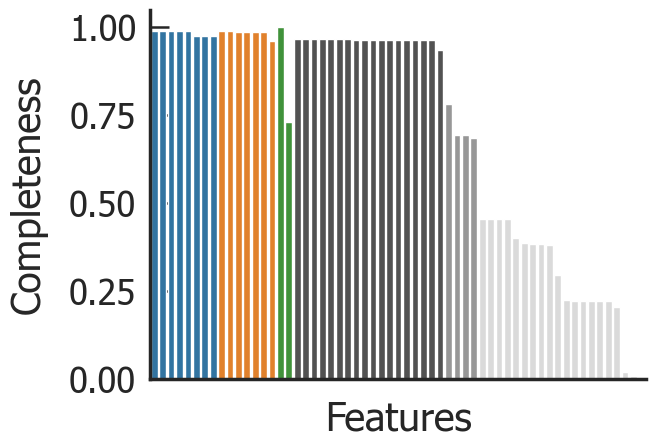

In [40]:
sns.barplot(data=df, x='Features', y='Completeness', hue='Group', palette=color_mapping, hue_order=list(color_mapping.keys()), legend=False)
# sns.move_legend(plt.gca(), bbox_to_anchor=(.9, 1), loc='upper left', title='', frameon=False)
plt.xticks(ticks=[], labels=[], rotation=90)
# plt.savefig("../plots/240530_feature_completeness_script.png", dpi=150, transparent=True, bbox_inches='tight')